In [ ]:
#@title
!pip install tensorflow-gpu==2.0.0
!pip install easydict
!pip install fbprophet

     |████████████████████████████████| 380.8MB 40kB/s 
     |████████████████████████████████| 3.8MB 41.4MB/s 
     |████████████████████████████████| 450kB 54.3MB/s 
     |████████████████████████████████| 81kB 13.0MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.2 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found exist

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
pandoc set to manually installed.
The following packages were automatically installed and are no longer required:
  cuda-cufft-10-1 cuda-cufft-dev-10-1 cuda-curand-10-1 cuda-curand-dev-10-1
  cuda-cusolver-10-1 cuda-cusolver-dev-10-1 cuda-cusparse-10-1
  cuda-cusparse-dev-10-1 cuda-license-10-2 cuda-npp-10-1 cuda-npp-dev-10-1
  cuda-nsight-10-1 cuda-nsight-compute-10-1 cuda-nsight-systems-10-1
  cuda-nvgraph-10-1 cuda-nvgraph-dev-10-1 cuda-nvjpeg-10-1
  cuda-nvjpeg-dev-10-1 cuda-nvrtc-10-1 cuda-nvrtc-dev-10-1 cuda-nvvp-10-1
  libcublas10 libnvidia-common-430 nsight-compute-2019.5.0
  nsight-systems-2019.5.2
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  libcupsfilters1 libcupsimage2 libgs9 libgs9-common libijs

In [ ]:
!cp 'drive/My Drive/Colab Notebooks/SeriesTemporales.ipynb' ./
!jupyter nbconvert --to html "SeriesTemporales.ipynb"

[NbConvertApp] Converting notebook SeriesTemporales.ipynb to html
/usr/local/lib/python2.7/dist-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) [u'application/vnd.colab-display-data+json'] is not able to be represented.
  mimetypes=output.keys())
[NbConvertApp] Writing 3456161 bytes to SeriesTemporales.html


In [ ]:
#@title  
from datetime import datetime
import easydict
import csv
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Lambda, Subtract, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import logging
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K, initializers, regularizers, constraints
import warnings
import pandas as pd
from pylab import rcParams
import numpy as np
from fbprophet import Prophet
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import matplotlib.dates as md

np.random.seed(0)
warnings.simplefilter("ignore")
warnings.filterwarnings('ignore')
print(tf.__version__)

2.0.0


In [ ]:
#@title
def mean_absolute_percentage_error(y_true, y_pred): 

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
#@title
class DataGenerator(tf.keras.preprocessing.sequence.TimeseriesGenerator):
    def __init__(self, data, targets, length,
                 sampling_rate=1,
                 stride=1,
                 start_index=0,
                 end_index=None,
                 shuffle=False,
                 reverse=False,
                 batch_size=8,
                n_outputs=24):

        if len(data) != len(targets):
            raise ValueError('Data and targets have to be' +
                             ' of same length. '
                             'Data length is {}'.format(len(data)) +
                             ' while target length is {}'.format(len(targets)))

        self.data = data
        self.targets = targets
        self.length = length
        self.sampling_rate = sampling_rate
        self.stride = stride
        self.start_index = start_index + length
        if end_index is None:
            end_index = len(data) - 1
        self.end_index = end_index
        self.shuffle = shuffle
        self.reverse = reverse
        self.batch_size = batch_size
        self.n_outputs = n_outputs

        if self.start_index > self.end_index:
            raise ValueError('`start_index+length=%i > end_index=%i` '
                             'is disallowed, as no part of the sequence '
                             'would be left to be used as current step.'
                             % (self.start_index, self.end_index))

    def __len__(self):
        return (self.end_index - self.start_index +
                self.batch_size * self.stride) // (self.batch_size * self.stride)

    def __getitem__(self, index):
        if self.shuffle:
            rows = np.random.randint(
                self.start_index, self.end_index + 1, size=self.batch_size)
        else:
            i = self.start_index + self.batch_size * self.stride * index
            rows = np.arange(i, min(i + self.batch_size *
                                    self.stride, self.end_index + 1), self.stride)

        samples = np.array([self.data[row - self.length:row:self.sampling_rate]
                            for row in rows])
        targets = np.array([self.targets[row:row+self.n_outputs] for row in rows])

        if self.reverse:
            return samples[:, ::-1, ...], targets
        return samples, targets

In [ ]:
#@title
def rse(y_true, y_pred):
    #
    # The formula is:
    #           K.sqrt(K.sum(K.square(y_true - y_pred)))     
    #    RSE = -----------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)))       
    #
    #           K.sqrt(K.sum(K.square(y_true - y_pred))/(N-1))
    #        = ----------------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)/(N-1)))
    #
    #
    #           K.sqrt(K.mean(K.square(y_true - y_pred)))
    #        = ------------------------------------------
    #           K.std(y_true)
    #
    num = K.sqrt(K.mean(K.square(y_true - y_pred), axis=None))
    den = K.std(y_true, axis=None)
    
    return num / den

def rse_prediction(y_true, y_pred):
    #
    # The formula is:
    #           K.sqrt(K.sum(K.square(y_true - y_pred)))     
    #    RSE = -----------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)))       
    #
    #           K.sqrt(K.sum(K.square(y_true - y_pred))/(N-1))
    #        = ----------------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)/(N-1)))
    #
    #
    #           K.sqrt(K.mean(K.square(y_true - y_pred)))
    #        = ------------------------------------------
    #           K.std(y_true)
    #
    num = K.sqrt(K.mean(K.square(K.constant(y_true) - K.constant(y_pred)), axis=None))
    den = K.std(K.constant(y_true), axis=None)
    
    return num / den

def rmse(y_true, y_pred):
	return K.sqrt(K.mean(K.square(y_pred - y_true)))

def corr(y_true, y_pred):
    #
    # This function calculates the correlation between the true and the predicted outputs
    #
    num1 = y_true - K.mean(y_true, axis=0)
    num2 = y_pred - K.mean(y_pred, axis=0)
    
    num  = K.mean(num1 * num2, axis=0)
    den  = K.std(y_true, axis=0) * K.std(y_pred, axis=0)
    
    return K.mean(num / den)

tf.keras.utils.get_custom_objects().update({"rmse": rmse, 'rse': rse, 'corr':corr})

In [ ]:
#@title
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        # todo: check that this is correct
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)


class Attention(Layer):
    def __init__(self,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True,
                 return_attention=False,
                 **kwargs):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Note: The layer has been tested with Keras 1.x
        Example:
        
            # 1
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
            # next add a Dense layer (for classification/regression) or whatever...
            # 2 - Get the attention scores
            hidden = LSTM(64, return_sequences=True)(words)
            sentence, word_scores = Attention(return_attention=True)(hidden)
        """
        self.supports_masking = True
        self.return_attention = return_attention
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        eij = dot_product(x, self.W)

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        weighted_input = x * K.expand_dims(a)

        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return input_shape[0], input_shape[-1]

In [ ]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Máster Oficial en Investigación en Inteligencia Artificial - Datos temporales y complejos
## Series temporales - Predicción de la demanda eléctica

### Índice
1. Análisis de los datos
2. Preprocesado
3. Modelado
4. Evaluación

### Análisis de los datos

Durante esta parte, se estudiarán distintas métricas y visualizaciones de los datos con el objetivo de obtener un mayor conocimiento de estos y ayudar a la hora de realizar el modelado.

In [ ]:
demand = pd.read_excel('Demanda_2015.xlsx', header=None)
demand.columns = ['date', 'time', 'demand']
demand['datetime'] = pd.to_datetime(demand['date'].astype(str)+" "+demand['time'].astype(str), format='%Y-%m-%d %H:%M:%S')
demand.drop(['date', 'time'], inplace=True, axis=1)
demand = demand.set_index('datetime')

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


En primer lugar se mostará una muestra de los datos para poder observar y qué formato tiene.

In [ ]:
demand.head()

,demand
datetime,
2015-01-01 00:00:00,25459
2015-01-01 00:10:00,25591
2015-01-01 00:20:00,25531
2015-01-01 00:30:00,25453
2015-01-01 00:40:00,25329


Como se observa, los datos constan de tres columnas donde la primera denota la fecha y la segunda la hora en la que tuvo en la que tuvo lugar la medida de demanda, por último, la demanda en sí es la última columna que se muestra. Se puede observar que los datos son muestreados cada 10 minutos. Por lo tanto, se trata de una serie temporal univariada, en la que la variable a predecir solo dependerá de sus propios valores pasados.

En segundo lugar, se mostrarán una serie de estadísticas sobre los datos que resumirán una serie de estadísticos.

In [ ]:
demand.describe()

,demand
count,52560.000000
mean,28348.614212
std,4671.815664
min,17985.000000
25%,24392.000000
50%,28566.000000
75%,31664.000000
max,40648.000000


In [ ]:
demand.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52560 entries, 2015-01-01 00:00:00 to 2015-12-31 23:50:00
Data columns (total 1 columns):
demand    52560 non-null int64
dtypes: int64(1)
memory usage: 3.3 MB


Se puede observar que no existen valores perdidos de ningún tipo. Los valores se encuentran en el rango [17985, 40648] y la desviación típica es de 4671,82.

A continuación se mostrarán una serie de gráficas con el objetivo de obtener una mayor intuición de los datos.

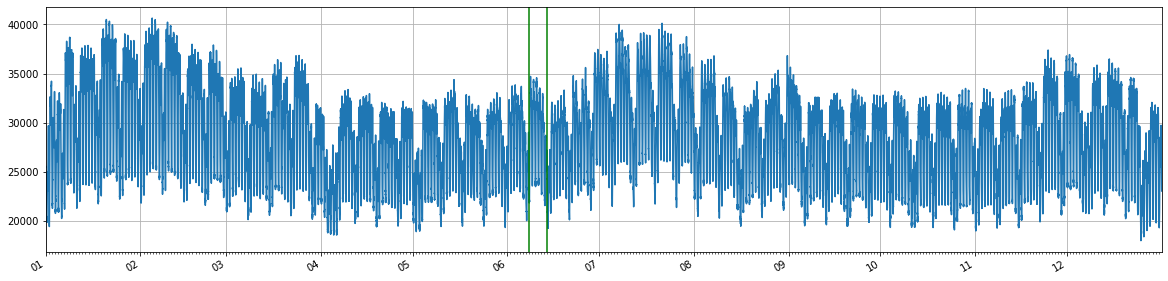

In [ ]:
days = mdates.DayLocator()   # every year
months = mdates.MonthLocator()  # every month
months_fmt = mdates.DateFormatter('%m')
fig, ax = plt.subplots(figsize=(20,5))
ax.plot( 'demand', data=demand)
ax.axvline(datetime(2015, 6, 8), color='green')
ax.axvline(datetime(2015, 6, 14), color='green')
# format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)
ax.xaxis.set_minor_locator(days)

# round to nearest years.
datemin = np.datetime64(demand.index[0], 'm')
datemax = np.datetime64(demand.index[-1], 'm') + np.timedelta64(1, 'm')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

La visualización de toda la serie temporal nos indica que existen ciertas oscilaciones a lo largo del año. Por ejemplo, se muestra que a poco después del principio, en mitades y poco antes de finales de año existe una mayor demanda. Estos intervalos donde existe una mayor demanda se corresponden con febrero, mitades de junio y diciembre. Cabe esperar estos picos dado que se correponden con valores en pleno invierno y pleno verano. En color verde se ha dibujado dos lineas verdes la zona entre estas dos líneas corresponderían con los datos a predecir.

A continuación se mostrarán un histograma para poder observar la distribución de los datos de demanda. A continuación, se mostrará la media y la desviación típica a través de ventanas deslizantes promedios en las que se divide la serie temporal. Para esta representación se ha tomado dos frecuencias posibles, mensual y semanal. 
Con el objetivo de analizar la estacionalidad de los datos se realizarán tres pruebas. En primer lugar se analizará la media y varianza a través de una ventana deslizante. Tras ello se descompondrá la serie temporal en sus componenentes. Por último, se realizará el test de Dickey-Fuller.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f019d4e1c50>]],
      dtype=object)

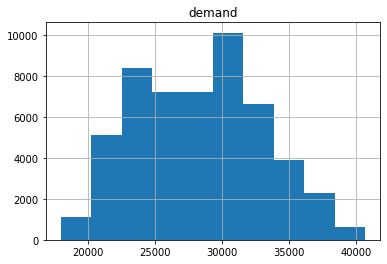

In [ ]:
demand.hist()

Como puede observarse los datos poseen una distribución normal de los datos donde la mdedia se encuentra entre los 30000 kw.


In [ ]:
def plot_rolling(df, window_size, title):
    fig, ax = plt.subplots(figsize=(12, 9))
    
    ax.plot('demand', data=demand)
    ax.plot(df.index,df.demand.rolling(window=window_size).mean(), label="rolling mean");
    ax.plot(df.index,df.demand.rolling(window=window_size).std(), label="rolling std");
    ax.legend()

    plt.tight_layout()
    plt.title(title)
    fig.autofmt_xdate()

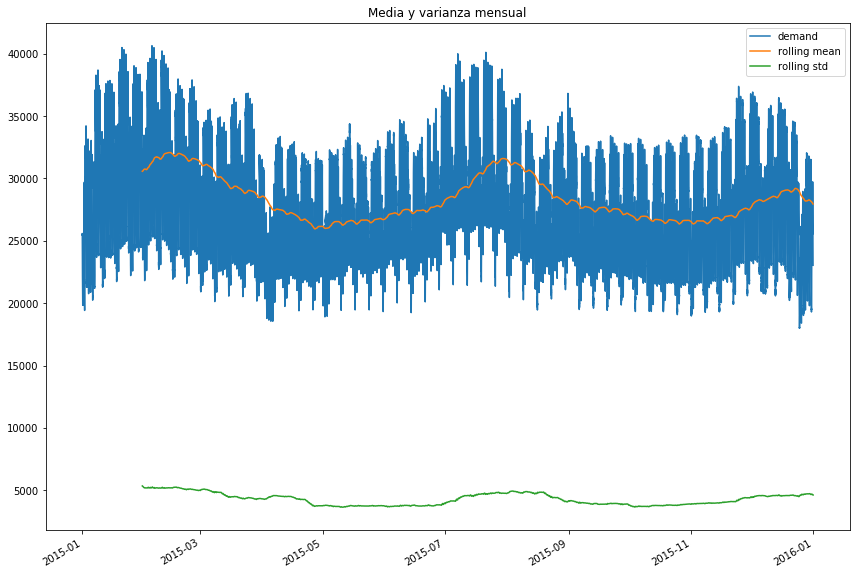

In [ ]:
plot_rolling(demand, 30*24*6, "Media y varianza mensual")

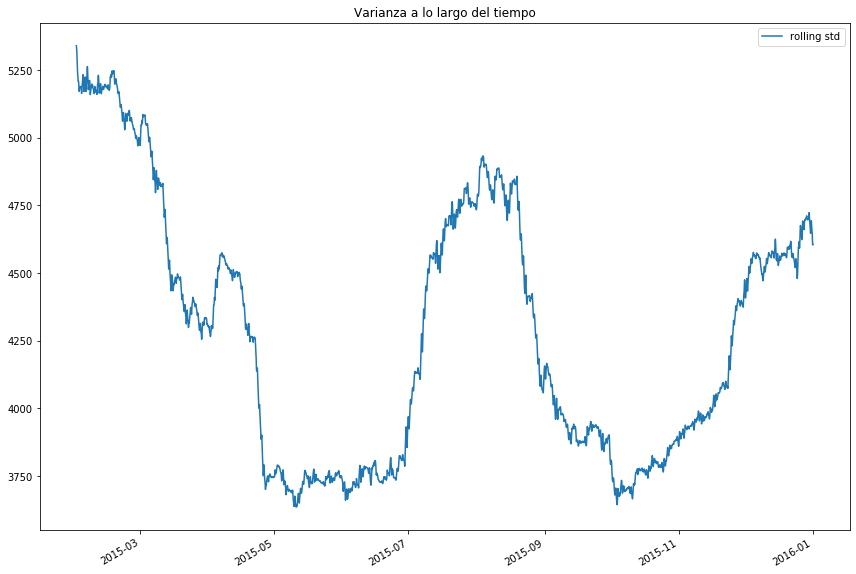

In [ ]:
fig, ax = plt.subplots(figsize=(12, 9))

ax.plot(demand.index, demand.rolling(window=30*24*6).std(), label="rolling std");
ax.legend()

plt.tight_layout()
plt.title("Varianza a lo largo del tiempo")
fig.autofmt_xdate()

Como puede observarse, la varianza a principios, mitades y finales de año son mucho mayores, por lo que durante esta época se cometerá un mayor error probablemente a la hora de realizar predicciones.

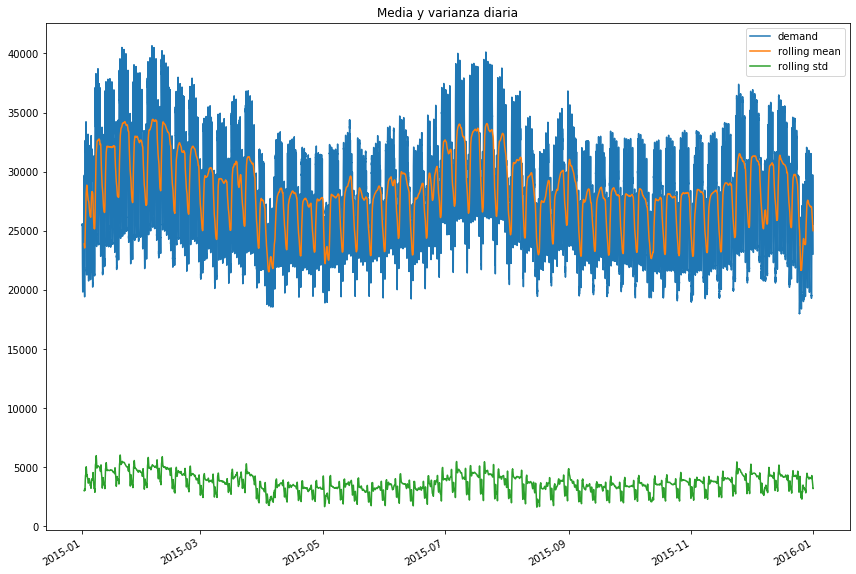

In [ ]:
plot_rolling(demand, 24*6, "Media y varianza diaria")

La media y la desviación típica es constante en el tiempo tomando una frecuencia mensual y seudo constante tomando una frecuencia diaria.

A continuación, se mostrará la descomposición de la serie temporal.

Con una frecuencia mensual asumida, se percibe que la tendencia sufre fluctuaciones, pero no se observa que exista una tendencia creciente o decreciente. Por otro lado, no se percibe que de forma mensual exista una estacionalidad clara, aunque si se perciben ciertas bajadas que pueden indicar estacionalidad un pequeña estacionalidad. Por oto lado, analizando la gráfica residual se pueden analizar la aparición de algún valor atípico, se pueden apreciar ciertos valores atípicos que en pasos posteriores se estudiarán.

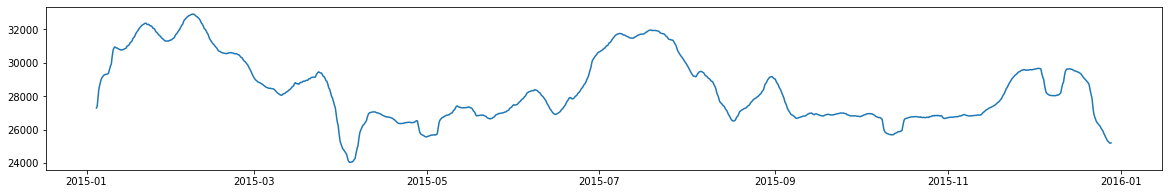

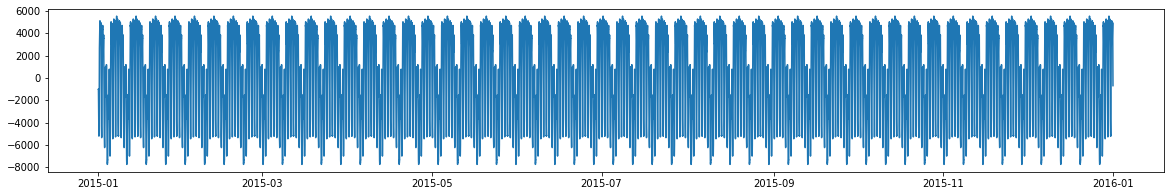

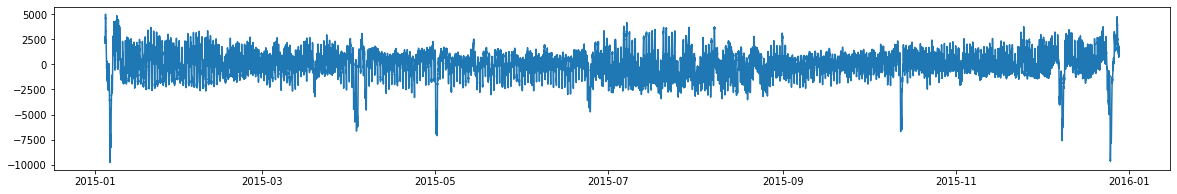

In [ ]:
rcParams['figure.figsize'] = 20, 3
descomposed_demand = sm.tsa.seasonal_decompose(demand["demand"],freq=7*24*6) # Monthly frequency
plt.plot(descomposed_demand.trend)
plt.figure()
plt.plot(descomposed_demand.seasonal)
plt.figure()
plt.plot(descomposed_demand.resid)

plt.show()

Estableciendo una frecuencia semanal la tendencia no muestra ningun incremento o decremento. Sin embargo, la estacionalidad puede verse claramente definida en este caso en las fluctuaciones periódicas, por ello se puede decir que existe claramente una estacionalidad semanal en los datos. En cuanto al estudio de los residuos, se observa más claramente los datos atípicos donde el error es mayor.

Por último y para terminar de asegurar la estacionalidad se realizará el test de Dickey-Fuller.

In [ ]:
from statsmodels.tsa.stattools import adfuller

print(" > Is the data stationary ?")
dftest = adfuller(demand.demand, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    

 > Is the data stationary ?
Test statistic = -21.669
P-value = 0.000
Critical values :
	1%: -3.4304745618132237 - The data is  stationary with 99% confidence
	5%: -2.8615950538210817 - The data is  stationary with 95% confidence
	10%: -2.566799303318103 - The data is  stationary with 90% confidence


Como se observa, realizando contraste de hipótesis se demuestra que no existen evidencia suficientes como para rechazar la hipótesis de estacionalidad, por lo tanto se comprueba que se trata de una sere estacionaria.

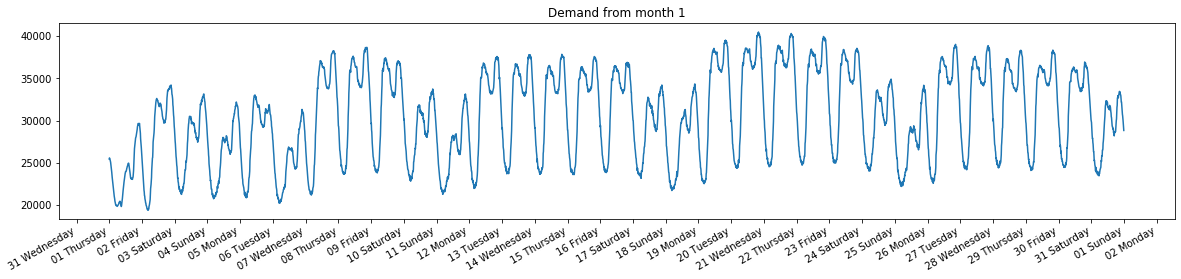

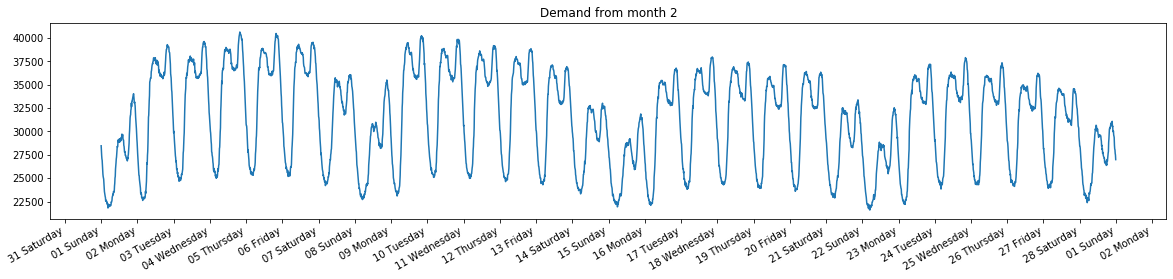

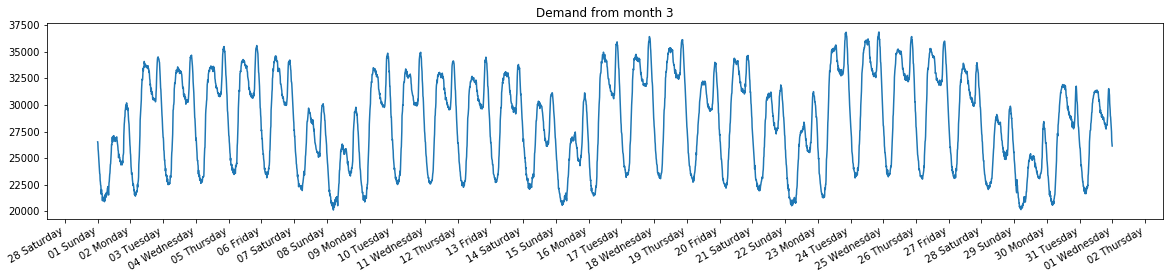

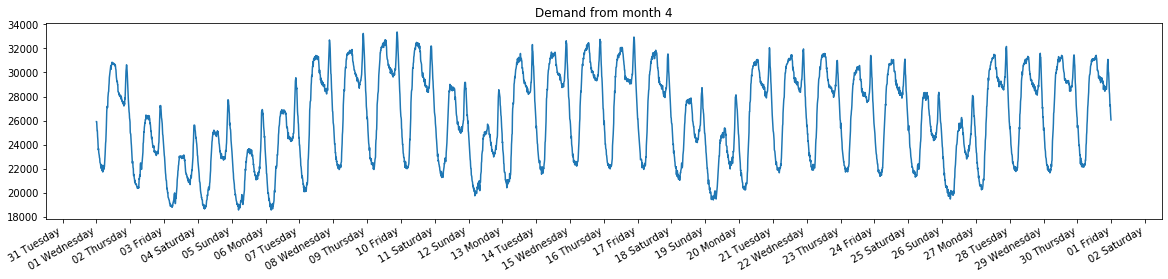

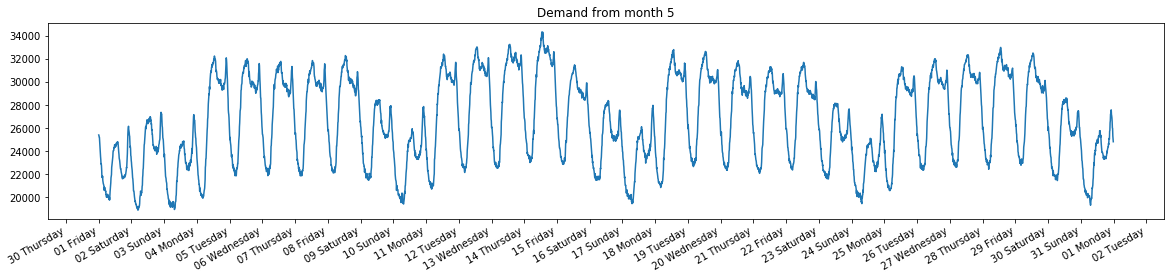

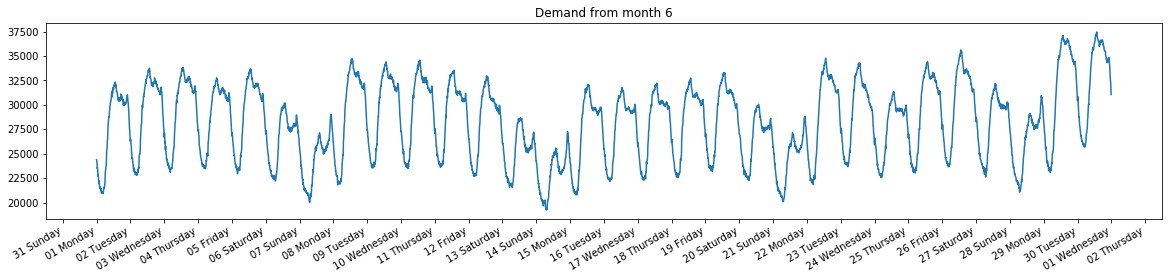

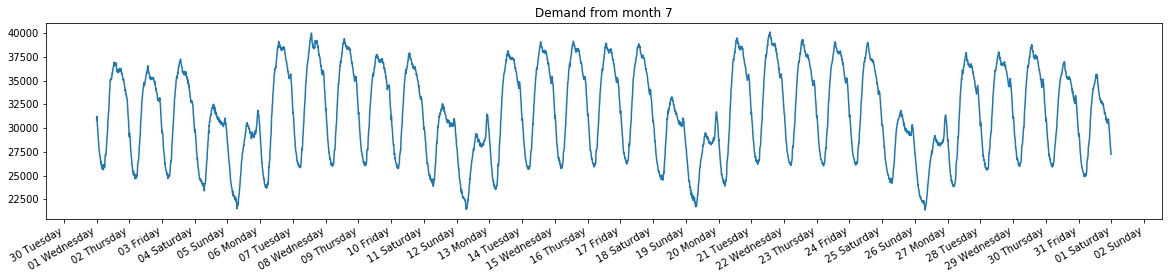

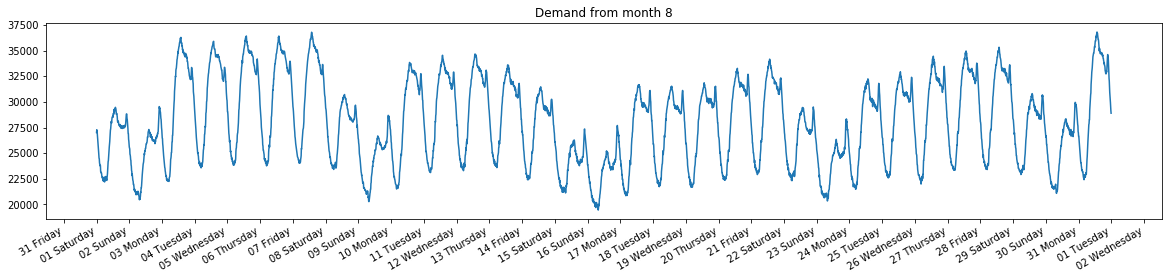

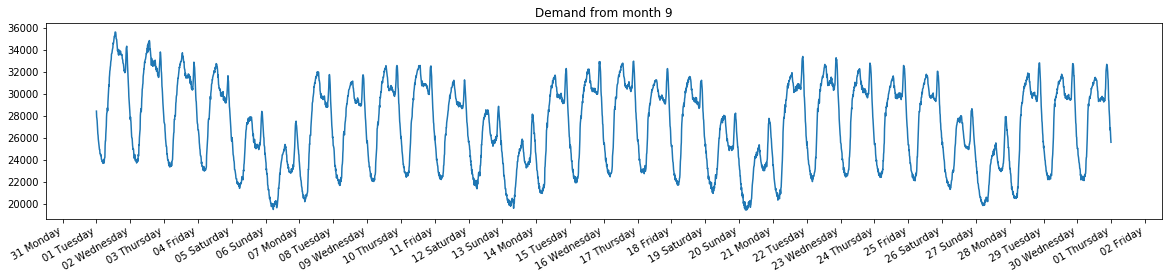

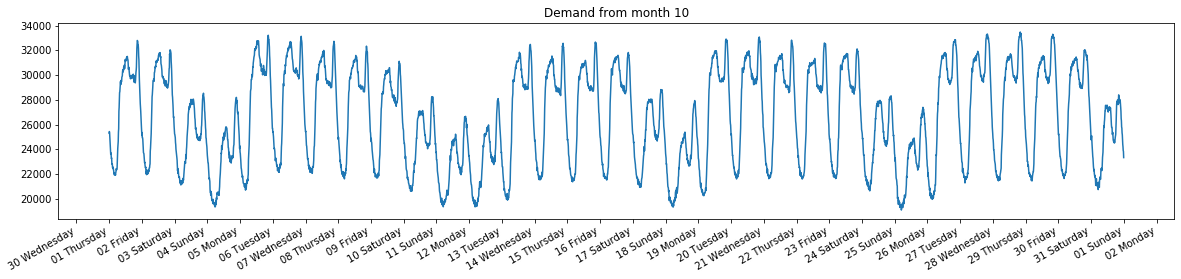

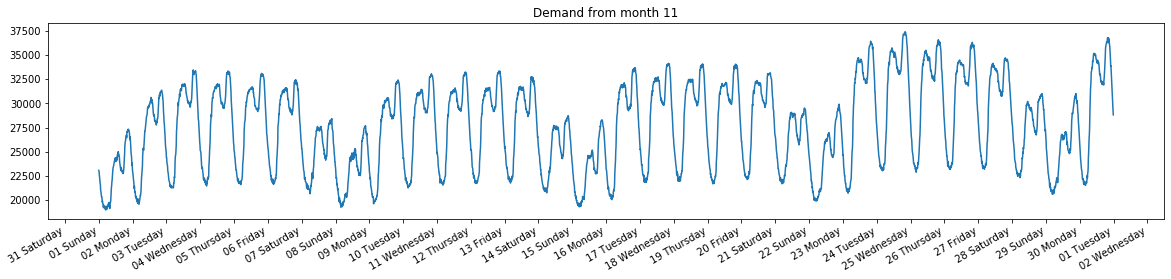

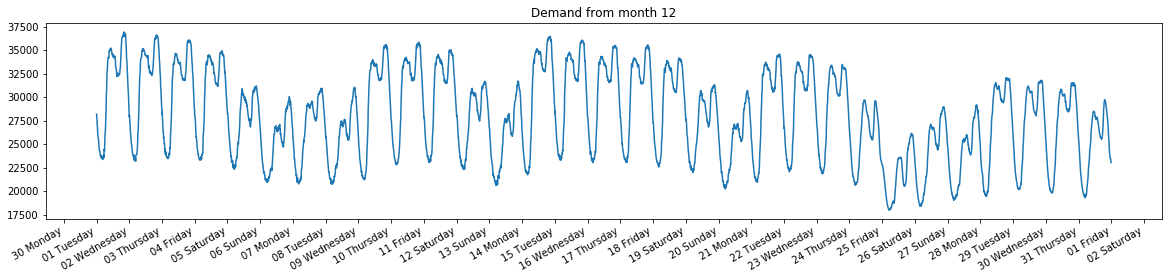

In [ ]:
for month in range(1,13):

    plt.figure(figsize=(20,4))
    plt.title("Demand from month "+str(month))
    p = demand[demand.index.strftime("%m").astype(int)==month] 
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %A'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.plot(p.index, p["demand"])
    plt.gcf().autofmt_xdate()
    plt.show()

A través de estas gráficas se puede observar como los meses poseen un comportamiento estacionario. Se observa como en la mayoría de los casos, de martes a sábado el consumo es alto y el domingo decae. También puede apreciarse que los días festivos esta regla no se cumple, por ejemplo en el caso del día 8 y 9 de diciembre se observan unos valors menores a lo común coincidiendo con festividades españolas. Este comportamiento da a pensar que se trata de un lugar o edificio donde trabajen personas o una casa normal donde los fines de semana suele salir de vacaciones o viaje explicando el comportamiento de los festivos y fines de semana. Sin embargo, el hecho de que el mayor consumo sea de martes a domingo no es intuitivo en ese sentido.

Para poder analizar mejor el comportamiento de la serie temporal se visualizará una semana día a día para observar su evolución.

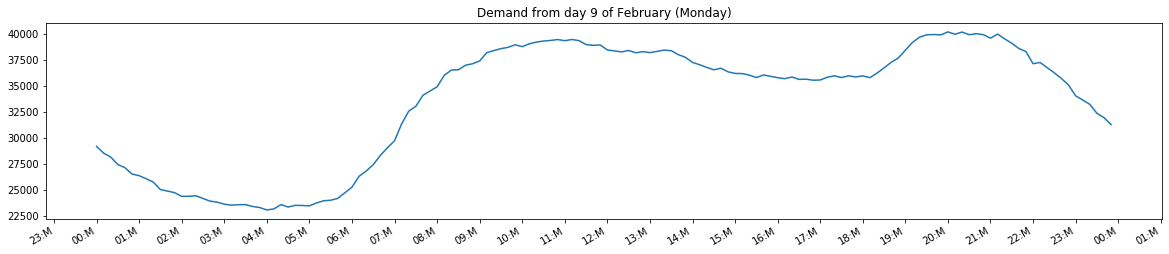

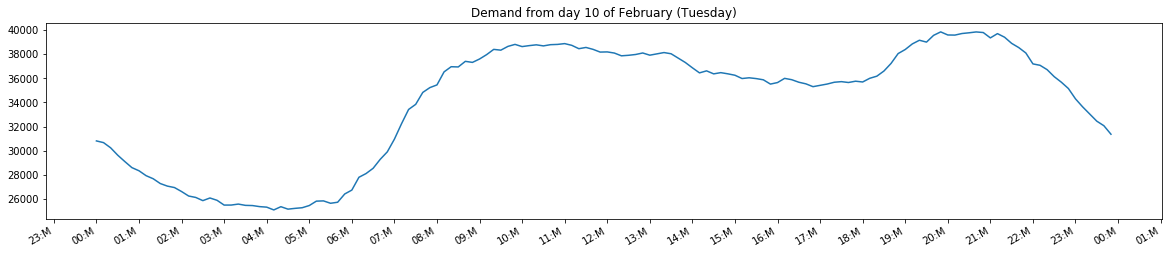

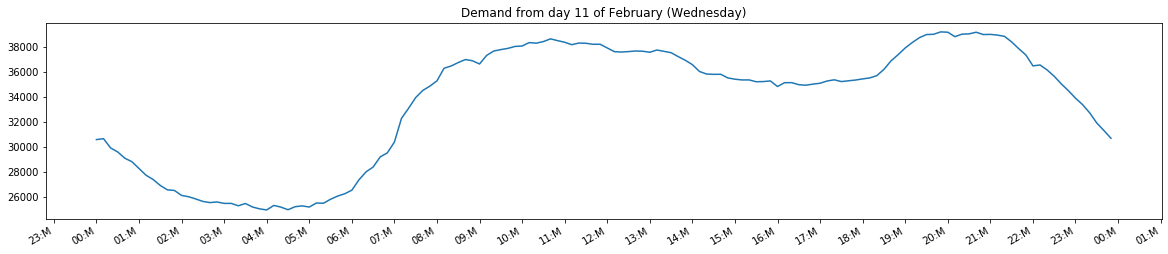

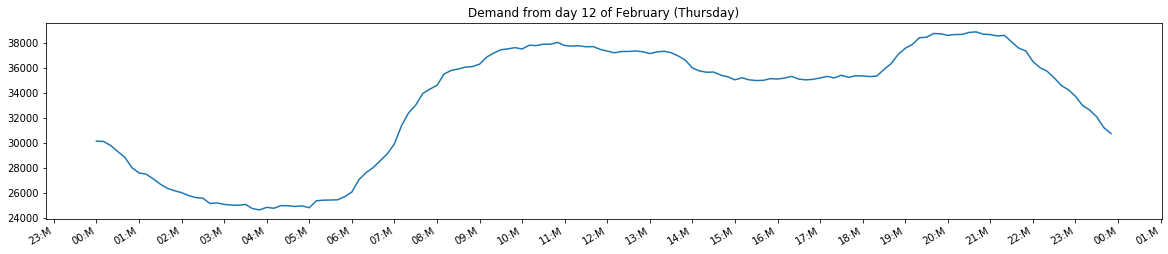

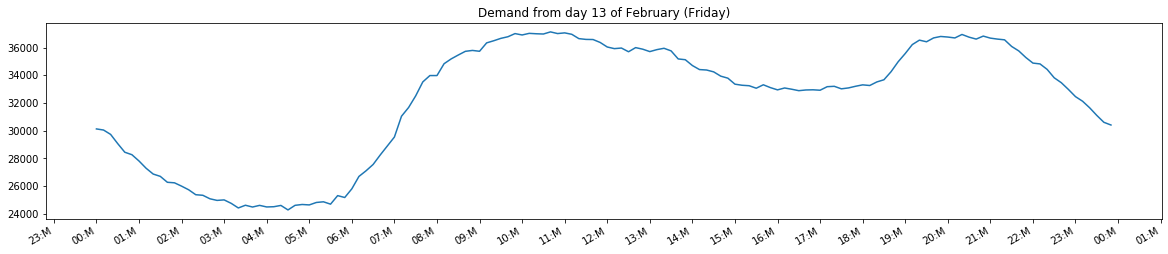

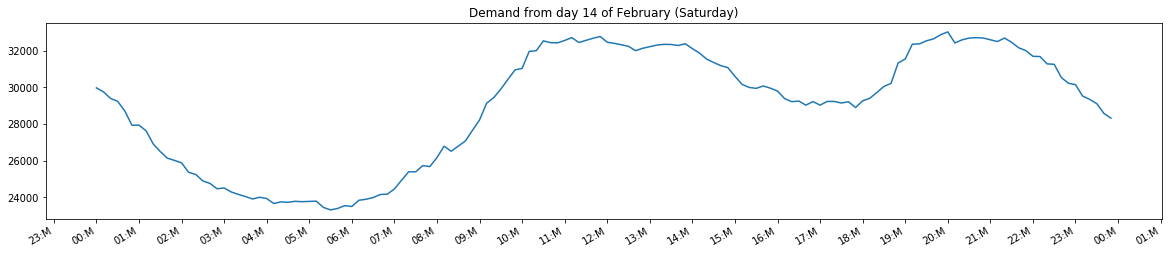

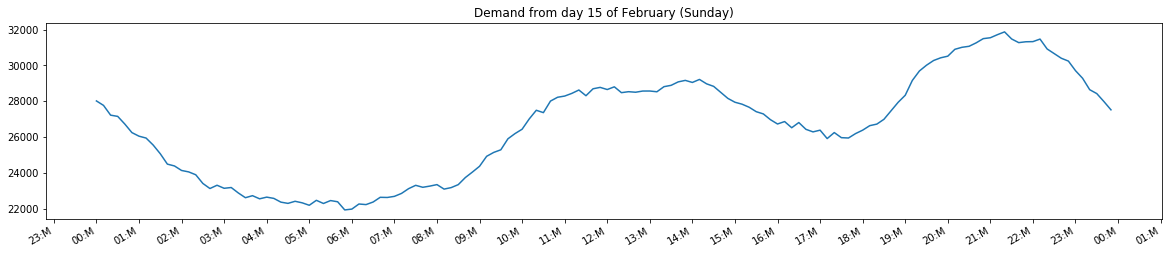

In [ ]:
for d in range(9, 16):
    plt.figure(figsize=(20,4))

    p = demand[(demand.index.strftime("%m").astype(int)==2) & (demand.index.strftime("%d").astype(int)==d)]
    plt.title("Demand from day "+str(d) +" of February ("+p.index.strftime("%A")[0]+")")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:M'))
    plt.gca().xaxis.set_major_locator(mdates.HourLocator())
    plt.plot(p.index, p["demand"])
    plt.gcf().autofmt_xdate()
    plt.show()

Se ha escogido un día aparentemente normal para poder estudiar el comportamiento de la serie temporal de forma diaria. Se observa como la demanda cae hasta valores mínimos entre las 2 y 6 de la mañana excepto en los fines de semana que se alarga hasta las 7-8 en el caso del sábado y hasta incluso 8-9 en el caso de los domingos. Existen dos máximos locales comprendidos entre las 10 am - 15 pm y las 7pm - 12pm. Este comportamiendo da a pensar que se trata de un hogar.

A continuación, Se mostrará la autocorrelación de los datos con el objetivo de descubrir qué intervalos de tiempo están mas correlados.

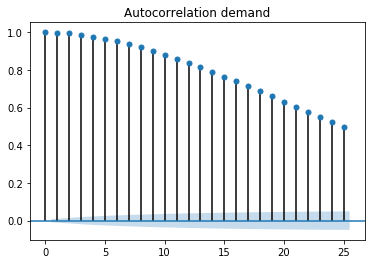

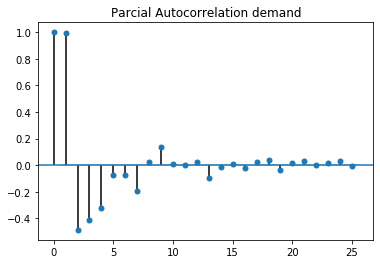

In [ ]:
plot_acf(demand["demand"],lags=25,title="Autocorrelation demand")
plt.show()

plot_pacf(demand["demand"],lags=25,title="Parcial Autocorrelation demand")
plt.show()

Mediante el estudio de la autocorrelación se pueden observar los valores temporales que están correlados, se observa que la correlación va decreciendo conforme más alejado en el tiempo se encuentra del dato actual. Por otro lado, la correlación parcial muestran valores mayores en los primeros valores y muy pequeños en los valores más alejados del tiempo. Esto indica que un modelo de Autoregresión es sería adecuado donde el valor de predicción sera una conbinación de los valores pasados.

Por lo tanto nos encontramos tras una serie temporal estacionaria con estacionalidad diaria y en el que pueden existir valores atípicos en épocas del año que coincidan con festivos y en el que los fines se comportan de distinta forma a los demás días de la semana.


### Outliers


Una vez analizado el comportamiento de los datos se estudiará la detección y obtención de outliers en más detalle. Para ello, es necesario definir qué se entenderá como outlier. Se considerarán como outliers a todo comportamiento fuera de los esperado, estos comportamientos pueden ser: cambios en la tendencia de los datos, pícos fuera de lo común, caídas y cambios de nivel en la serie temporal. 



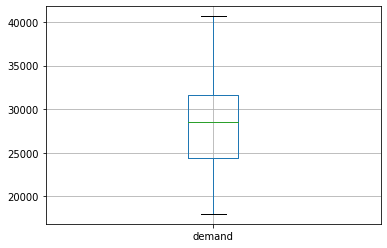

In [ ]:
demand.boxplot()

Analizando un diagrama de cajas y bigotes, no se observan ningún valor atípico. Por lo tanto, es necesario estudiarlos mediante técnicas específicas para series temporales. Para ello en primer lugar se usará la librería prophet con el que se creará unos límites en los que los valores de la serie temporal deberían moverse a través de una predicción realizada sobre la serie temporal parecida a Auto-ARIMA.

In [ ]:
demand_outlier = demand.copy()

demand_outlier.columns = ['y']

demand_outlier['ds'] = demand.index
demand_outlier.index = range(len(demand.index))

def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.8):
    m = Prophet(daily_seasonality = True, yearly_seasonality = False, weekly_seasonality = True,
                interval_width = interval_width,
                changepoint_range = changepoint_range)

    m = m.fit(dataframe)
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    return forecast
    
pred = fit_predict_model(demand_outlier)

In [ ]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

pred = detect_anomalies(pred)

In [ ]:
pred

,ds,trend,yhat,yhat_lower,yhat_upper,fact,anomaly,importance
0,2015-01-01 00:00:00,25844.450638,26103.167326,21602.795913,30708.824629,25459,0,0.000000
1,2015-01-01 00:10:00,25847.714165,25754.351566,20994.674290,30442.239871,25591,0,0.000000
2,2015-01-01 00:20:00,25850.977693,25415.205555,20835.851898,29554.502519,25531,0,0.000000
3,2015-01-01 00:30:00,25854.241220,25087.399529,20230.369242,29849.987759,25453,0,0.000000
4,2015-01-01 00:40:00,25857.504747,24772.280353,20347.774389,29740.071303,25329,0,0.000000
...,...,...,...,...,...,...,...,...
52555,2015-12-31 23:10:00,28222.453711,29701.474668,25120.706764,34509.169523,23506,-1,0.068693
52556,2015-12-31 23:20:00,28222.565839,29335.964644,24867.717084,33854.068679,23502,-1,0.058111
52557,2015-12-31 23:30:00,28222.677966,28967.631762,23995.577444,33386.596586,23407,-1,0.025145
52558,2015-12-31 23:40:00,28222.790094,28599.484589,23689.166887,33466.338688,23230,-1,0.019766


Los resultados obtenidos de aplicar el modelo proporcionado por prophet contiene los outliers detectados.

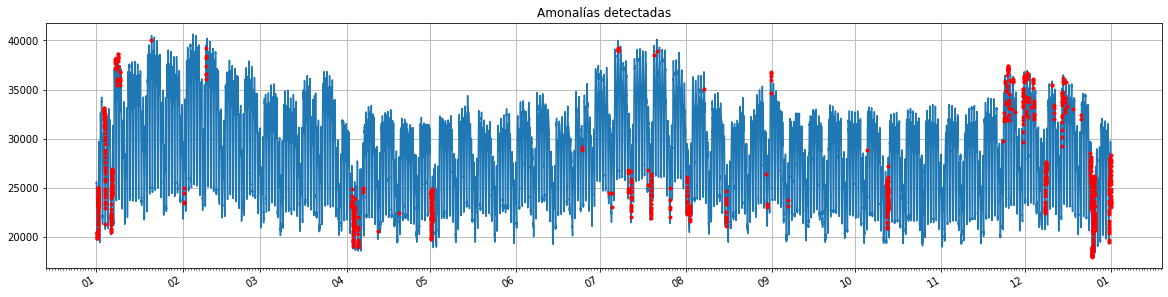

In [ ]:
def plot_anomalies(forecasted):
    days = mdates.DayLocator()   # every year
    months = mdates.MonthLocator()  # every month
    months_fmt = mdates.DateFormatter('%m')
    fig, ax = plt.subplots(figsize=(20,5))
    ax.plot('ds', 'fact', data=forecasted[forecasted.anomaly==0])
    ax.plot('ds', 'fact', data=forecasted[forecasted.anomaly!=0], linewidth=0,color='red', marker='.')

    #ax.axvline(datetime(2015, 6, 8), color='green')
    #ax.axvline(datetime(2015, 6, 14), color='green')
    # format the ticks
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(months_fmt)
    ax.xaxis.set_minor_locator(days)

    # round to nearest years.
    #datemin = np.datetime64(demand_outlier['ds'][0], 'm')
    #datemax = np.datetime64(demand_outlier['ds'].iloc[-1], 'm') + np.timedelta64(1, 'm')
    #ax.set_xlim(datemin, datemax)

    # format the coords message box
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
    ax.grid(True)

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    fig.autofmt_xdate()
    plt.title("Amonalías detectadas")

              
plot_anomalies(pred)

Text(0.5, 1.0, 'Residuo de la serie temporal')

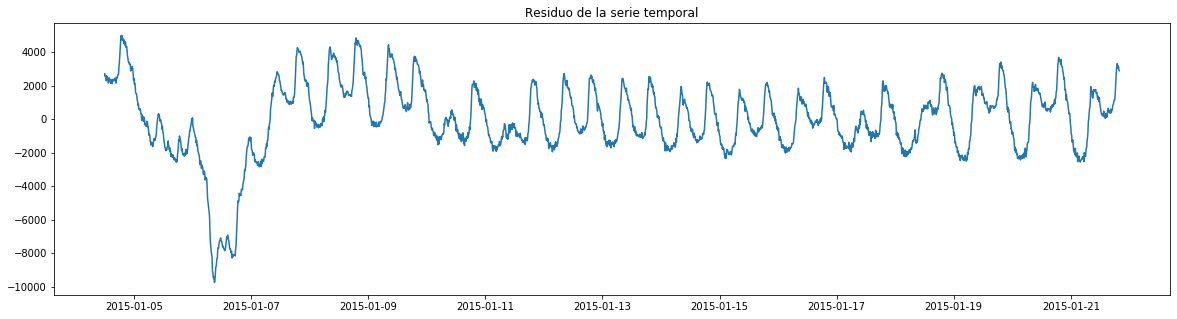

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(descomposed_demand.resid[:3000])
plt.title("Residuo de la serie temporal")

Como se puede observar, las anomalías detectadas coinciden en gran medida con los valores de residuo de la serie temporal que poseían unos valores por encima o debajo de los valores normales. Estos casos anormales pueden deberse a días festivos como se ha estudiado anteriormente, por lo que es de esperar que otro año este comportamiento se repita. El comportamiento no se trata de valores extremos fuera de lo común tal y como se ha visto en el diagrama de bigotes y cajas, si no de valores que están fuera de lo esperado dentro de la distribución creada. 
Para solucionar estos valores anómalos se podría sustituir estos valores por la media de la distribución, sin embargo, esta medida crearía situaciones donde habría un cambio brusco en los valores temporales. Es posible también realizar una interpolación, pero para ello haría falta entrenar un modelo que sea capaz de tener en cuenta la estacionalidad sin crear cambios bruscos en los datos. Por ello, se mantendrán los datos de la misma forma tal y como se encuentran.

### Modelado

Para la fase de modelado se ha escogido el modelo llamado LSTNet publicado en el artículo "Feed-Forward Networks with Attention Can Solve Some Long-Term Memory Problems" en la conferencia internacional de ICLR  en 2016. 

El modelo combina varias técnicas y estructuras dentro del ámbito del deep learning en el que el elemento principal es el mecanismo Attention. Cuando una capa LSTM toma una secuencia de datos, este forma tantos estados ocultos (h) como intervalos de tiempo. Estos estados ocultos representantan la información codificada desde ese intervalo de tiempo y todos los anteriores. Cuando el tamaño de la secuencia es demasiado grande, la información codificada en cada estado mantiene solo información más local, por lo que se pierde información relevante para la predicción. 
El mecanismo Attention toma todos los estados ocultos y realiza una ponderación en el que se pretende prestar más atención a aquellas partes que sean más relevantes para la predicción. De esta forma, se tiene en cuenta toda la información posible. El dar más atención o no a una parte de la secuencua de datos de entrada se obtiene a partir de una red feed-forward que recibe el estado anterior y el actual. 
El mecanismo Attention es ineficiente ya que para poder obtener los valores de ponderación es necesario conocer los estados ocultos anteriores, tratandose de un procesamiento secuencial. Para solucionar este problema, en el paper escogido se realizó una simplificación de este mecanismo donde el cálculo no se realiza teniendo en cuenta el estado anterior, si no que el cálculo de la ponderación solo depende de los valores actuales. Por lo que, la red feed-forward anteriormente mencionada cuyo objetivo era obtener las puntuaciones con las que se califica a qué parte de la secuencia prestar más atención, ahora solo dependerá del estado actual. Esta simplificación del mecanismo de Attention se le llama feed-forward attention. Además, en el mecanismo de Attention clásico es necesario el uso de una arquitectura de tipo enconder-decoder para poder aplicarse. Con la arquitectura propuesta en el paper no existe esta limitación, ya que el comportamiento de esta queda sujeta a una simple capa. 

Estructura: ![Feed-foward attention](https://d3i71xaburhd42.cloudfront.net/87119572d1065fb079e1dee8fcdb6c4811143f96/2-Figure1-1.png)

En la imagen se puede apreciar los elementos del feed-foward attention. a(ht) se trata de la función que calcula los scores para cada estado oculto h. Como se observa, se trata de una red feed-foward cuya entrada son los estados ocultos de la red. Como resultados se obtienen los scores alfa por cada estado oculto. Dando como resultado el vector c como salida.

Para realizar la predicción se usará una red neuronal con una capa LSTM y una capa feed-forward attention. Este modelo recibirá una ventana y dará como salida 4 horas en el futuro. Por lo que se tratará de un modelo univariante multisalida. Hay que tener en cuenta que por cada intervalo de tiempo (10) se tendrá una predicción de 4 horas por lo que habrá solapamiento entre las predicciones.

Previo al entrenamiento del modelo, se realizará un escalado de los datos mediante un MinMaxScaler con el objetivo de que la convergencia de la red neuronal sera más rápida. Los datos serán separados en entrenamiento, validación y prueba. Para que los resultados sean lo menos insesgados posibles, se obtendrán los parámetros para el escalado a partir de los datos de entrenamiento. A partir de estos parámetros, se escalarán los conjuntos de validación y prueba.

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_size = len(demand[:'2015-06-07'])

train = demand.iloc[:int(train_size*0.8),]
valid = demand.iloc[int(train_size*0.8):train_size,]
test = demand['2015-06-07':'2015-06-15']

data_train = scaler.fit_transform(train.values)
data_valid = scaler.transform(valid.values)
data_test = scaler.transform(test.values)

scaler_o3 = MinMaxScaler(feature_range=(0, 1))
scaled_o3 = scaler_o3.fit_transform(train)

In [ ]:
print(train.shape)
print(valid.shape)
print(test.shape)

(18201, 1)
(4551, 1)
(1296, 1)


In [ ]:
df_train = pd.DataFrame(data = data_train, columns = demand.columns, index=train.index)
df_valid = pd.DataFrame(data = data_valid,columns = demand.columns, index=valid.index)
df_test = pd.DataFrame(data = data_test, columns = demand.columns, index=test.index)

Los parámetros para la red neuronal serán las 4 horas de horizonte que se corresponden con 24 salidas. El modelo constará de una capa LSTM junto a una capa feed-forward attention y finalmente una capa full-connected del que saldrán las predicciones.

In [ ]:
horizont = 24
window = 24
batch_size=32
lr = 0.00001

train_generator = DataGenerator(df_train.values, df_train.values, length=window, end_index=len(df_train)-horizont, batch_size=batch_size)
valid_generator = DataGenerator(df_valid.values, df_valid.values, length=window, end_index=len(df_valid)-horizont, batch_size=batch_size)
test_generator = DataGenerator(df_test.values, df_test.values, length=window, end_index=len(df_test)-horizont, batch_size=batch_size)

In [ ]:
model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=( window, 1)),
            tf.keras.layers.LSTM(512, activation='relu', return_sequences=True),
            Attention(),
            tf.keras.layers.Dense(horizont)
        ])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=lr), loss='mae', metrics=[rmse,corr, rse, 'mae'])

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0000001)
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Electrical/checkpointsAttn/cpattn-{epoch:04d}.ckpt', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [ ]:
history = model.fit_generator(generator=train_generator,
                    validation_data=valid_generator,
                    use_multiprocessing=True,
                    callbacks=[reduce_lr, checkpoint],
                    epochs=200,
                    workers=12)

Epoch 92/200
563/564 [============================>.] - ETA: 0s - loss: 1.5602 - rmse: 7.1289 - corr: 0.5805 - rse: 31.5259 - mae: 1.5614WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1781: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /content/drive/My Drive/Electrical/checkpoints24h/cp24h-0092.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Electrical/checkpoints24h/cp24h-0092.ckpt/assets


564/564 [==============================] - 298s 528ms/step - loss: 1.5575 - rmse: 7.1164 - corr: 0.5810 - rse: 31.4722 - mae: 1.5587 - val_loss: 0.0777 - val_rmse: 0.0915 - val_corr: 0.5676 - val_rse: 1.6200 - val_mae: 0.0777
Epoch 93/200
563/564 [============================>.] - ETA: 0s - loss: 0.1008 - rmse: 0.1205 - corr: 0.5793 - rse: 1.4746 - mae: 0.1008INFO:tensorflow:Assets written to: /content/drive/My Drive/Electrical/checkpoints24h/cp24h-0093.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Electrical/checkpoints24h/cp24h-0093.ckpt/assets


564/564 [==============================] - 295s 523ms/step - loss: 0.1007 - rmse: 0.1204 - corr: 0.5799 - rse: 1.4733 - mae: 0.1007 - val_loss: 0.0777 - val_rmse: 0.0915 - val_corr: 0.5685 - val_rse: 1.6200 - val_mae: 0.0777
Epoch 94/200
563/564 [============================>.] - ETA: 0s - loss: 0.1006 - rmse: 0.1203 - corr: 0.5826 - rse: 1.4726 - mae: 0.1006INFO:tensorflow:Assets written to: /content/drive/My Drive/Electrical/checkpoints24h/cp24h-0094.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Electrical/checkpoints24h/cp24h-0094.ckpt/assets


564/564 [==============================] - 297s 527ms/step - loss: 0.1006 - rmse: 0.1202 - corr: 0.5817 - rse: 1.4718 - mae: 0.1006 - val_loss: 0.0777 - val_rmse: 0.0915 - val_corr: 0.5699 - val_rse: 1.6209 - val_mae: 0.0777
Epoch 95/200
564/564 [==============================] - 296s 524ms/step - loss: 0.1003 - rmse: 0.1200 - corr: 0.5845 - rse: 1.4698 - mae: 0.1003 - val_loss: 0.0778 - val_rmse: 0.0917 - val_corr: 0.5716 - val_rse: 1.6237 - val_mae: 0.0778
Epoch 96/200
564/564 [==============================] - 297s 527ms/step - loss: 0.1001 - rmse: 0.1197 - corr: 0.5891 - rse: 1.4670 - mae: 0.1001 - val_loss: 0.0781 - val_rmse: 0.0921 - val_corr: 0.5740 - val_rse: 1.6295 - val_mae: 0.0781
Epoch 97/200
564/564 [==============================] - 296s 525ms/step - loss: 0.0999 - rmse: 0.1195 - corr: 0.5919 - rse: 1.4653 - mae: 0.0999 - val_loss: 0.0784 - val_rmse: 0.0924 - val_corr: 0.5753 - val_rse: 1.6338 - val_mae: 0.0784
Epoch 98/200
564/564 [==============================] - 298s 

In [ ]:
tf.keras.models.load_model('/content/drive/My Drive/Electrical/checkpointsAttn/cpattn-0035.ckpt').save_weights('weights.h5')
model.load_weights('weights.h5')

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 24, 512)           1052672   
_________________________________________________________________
attention_5 (Attention)      (None, 512)               536       
_________________________________________________________________
dense_5 (Dense)              (None, 24)                12312     
Total params: 1,065,520
Trainable params: 1,065,520
Non-trainable params: 0
_________________________________________________________________


In [ ]:
predictions = model.predict_generator(test_generator)
predicted = scaler_o3.inverse_transform(predictions)
real = scaler_o3.inverse_transform(df_test.values)[window:-horizont+1]

In [ ]:
print(real.shape)
print(predicted.shape)

(1249, 1)
(1249, 24)


Para la evaluación se realizará la media de las métricas por cada predicción correspondiente a su valor real. Este es el valor que se realiza de media por cada predicción realizada. Sin embargo, en este cálculo se supone que se esperará a la entrada de un nuevo valor para realizar otra predicción de 4 horas. Para predecir el consumo eléctrico desde el 8 de junio hasta el 14 existen dos opciones sin tener que esperar a la entrada de nuevos datos reales:

* Obtener el primer valor de la predicción realizada e introducirla de nuevo en el modelo para predecir las siguientes 4 horas.

* Obtener las 4 horas de predicción e introducirlos en el modelo para predecir las siguientes 4 horas.

La primera forma es computacionalmente más compleja y acumula más pasos de predicción y por lo tanto más error. Sin embargo, debido a que el modelo usualmente obtendrá un menor error en los valores más cercanos al presente es posible que los errores no sean tan altos a pesar de iterar un mayor número de veces. La otra alternativa iterará un número menor de veces, pero acumulará más error por iteración probablemente.

El primer método no tendría sentido evaluarlo ya que sería mejor obtener un modelo con una sola salida en lugar de obtener un modelo multisalida como es el caso. Por lo tanto, se evaluará el segundo modelo.

In [ ]:
global_rmse = 0
global_rse = 0
global_mae = 0
global_mape = 0
for i in range(len(real)-horizont):

  global_rmse += rmse(real[i:i+horizont], predicted[i])/(len(real)-horizont)
  global_mae += mean_absolute_error(real[i:i+horizont], predicted[i])/(len(real)-horizont)
  global_mape += mean_absolute_percentage_error(real[i:i+horizont], predicted[i])/(len(real)-horizont)
  global_rse += rse_prediction(real[i:i+horizont], predicted[i])/(len(real)-horizont)
print("RMSE: "+str(global_rmse))
print("MAE: "+str(global_mae))
print("RSE: "+str(global_rse))
print("MAPE: "+str(global_mape))

RMSE: tf.Tensor(1887.2872490835755, shape=(), dtype=float64)
MAE: 1130.4345799452576
RSE: tf.Tensor(2.3609216, shape=(), dtype=float32)
MAPE: 5.942730119728212


Para la representación, se mostrarán las predicciones solapadas respecto la real mostrada en color rojo.

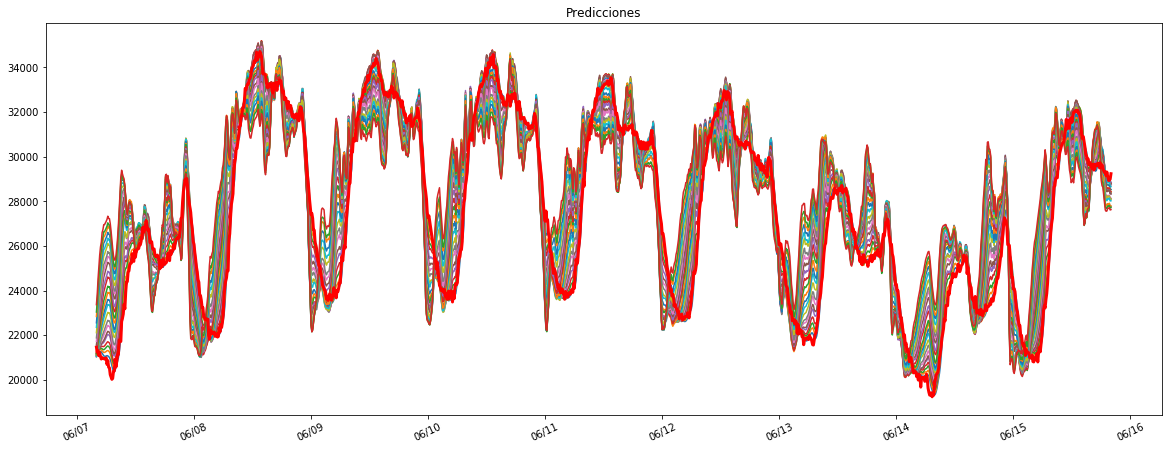

In [ ]:

plt.figure(1,figsize=(20,8))
plt.subplots_adjust(bottom=0.2)
plt.xticks(rotation=25)
ax=plt.gca()
ax.xaxis_date()
xfmt = md.DateFormatter('%m/%d')
ax.xaxis.set_major_formatter(xfmt)
plt.title(f'Predicciones')
plt.plot(test.index[window:-horizont+1], predicted)
plt.plot(test.index[window:-horizont+1], real, color='r', linewidth=3)

In [ ]:
input_values = np.array(df_test.iloc[:window])
final_prediction = []
for i in range(window, len(df_test), horizont):
  prediction = model.predict(input_values.reshape(1, window, 1))
  final_prediction.extend(prediction.reshape(horizont))
  input_values = np.concatenate((input_values[horizont:window+1], prediction.reshape(horizont, 1)[-horizont:]))

In [ ]:
np.array(final_prediction).reshape(1, -1).shape

(1, 1272)

In [ ]:
predicted = scaler_o3.inverse_transform(np.array(final_prediction).reshape(1, -1))[0]

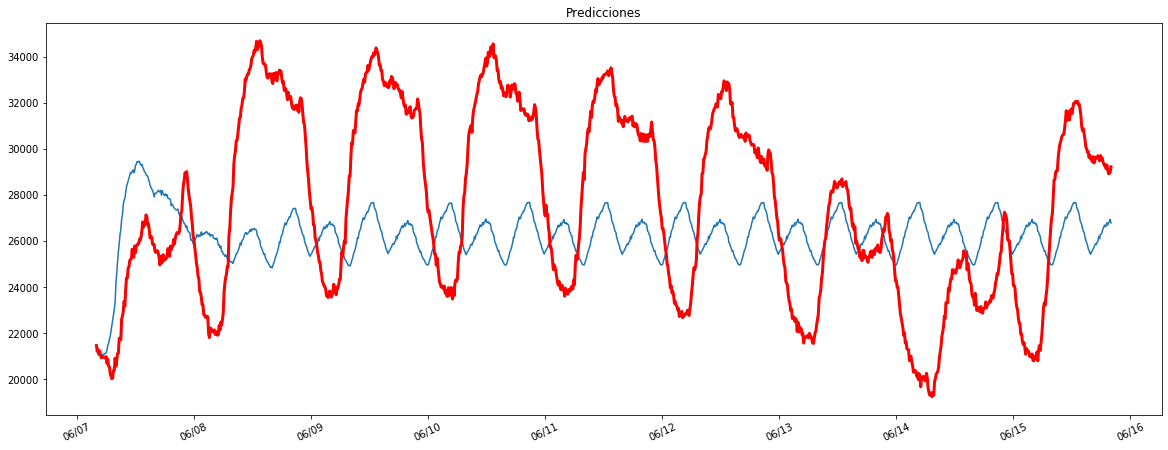

In [ ]:
plt.figure(1,figsize=(20,8))
plt.subplots_adjust(bottom=0.2)
plt.xticks(rotation=25)
ax=plt.gca()
ax.xaxis_date()
xfmt = md.DateFormatter('%m/%d')
ax.xaxis.set_major_formatter(xfmt)
plt.title(f'Predicciones')
plt.plot(test.index[window:-horizont+1], predicted[:-horizont+1])
plt.plot(test.index[window:-horizont+1], real, color='r', linewidth=3)

In [ ]:
result_df = pd.DataFrame(data = predicted[:-horizont+1], index=test.index[window:-horizont+1], columns=['demand'])

In [ ]:
result_df.to_csv('results.csv')

In [ ]:
global_rmse = rmse(real, predicted)
global_mae = mean_absolute_error(real, predicted[:-horizont+1])
global_mape = mean_absolute_percentage_error(real, predicted[:-horizont+1])
global_rse = rse_prediction(real, predicted)
print("RMSE: "+str(global_rmse))
print("MAE: "+str(global_mae))
print("RSE: "+str(global_rse))
print("MAPE: "+str(global_mape))

RMSE: tf.Tensor(4393.0461791656635, shape=(), dtype=float64)
MAE: 3709.1281775420334
RSE: tf.Tensor(1.0747302, shape=(), dtype=float32)
MAPE: 13.47935225616403


Tal y como se ve, la distribución tiende a una distribución estable repitiendo siempre el mismo patrón. Por lo que se puede observar que el modelo no es bueno para poder predecir la demanda a largo plazo. Aún sin realizar la predicción iterativa, el modelo comete un error alto probablemente debido a que el modelo necesita un mayor tiempo de entrenamiento.

### Conclusiones

Tal y como se ha visto, con un tiempo razonable se puede aproximar una serie temporal univariante con el mecanismo de feed-forward attention. Es necesario recalcar que experimentos realizados con ventanas mayores, produjeron peores resultados. De todo el proceso se han obtenido dos conclusiones por la parte de modelado:

* Es de vital importancia una buena elección de la ventana.
* Usando este método no se condiguen buenos resultados prediciendo de forma iterativa, es posible que otros tipos de redes como seq2seq produjeran mejores resultados de esta forma. Incluso abordarlo desde el punto de vista de una sola salida podría haber resultado en mejores resultados
